In [21]:
import pandas as pd
import numpy as np
import os

# read preprocessed data
cwd = os.getcwd()
df = pd.read_csv(cwd + "/data_csv/preprocessing_data.csv")
df.to_csv(cwd + "/data_csv/feature_data.csv", index=False)

In [22]:
df.groupby('emotion').count()

,image
emotion,
0,2521
1,1679
2,1568
3,2001
4,6396
5,5383
6,2273
7,2292


In [23]:
def get_distance(fist_point, second_point):
    distance =  math.sqrt(math.pow(fist_point[0] - second_point[0], 2) + math.pow(fist_point[1] - second_point[1], 2))
    return abs(distance)

def get_angle(first_point, second_point):
    angle = math.atan((second_point[1], first_point[1]) / (second_point[0], first_point[0]))
    return angle


In [24]:
import cv2, math, numpy as np, dlib
from imutils import face_utils

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(cwd + "/predictor/shape_predictor_68_face_landmarks.dat")

mlist = []
distlist = []
eye_size_list = []
eye_brows_list = []
width_left_eyes =[]
width_right_eyes = []
width_mount = []
height_mount = []
height_mount_chin = []
left_eye_list = []
right_eye_list = []
angle_left_eyebrow = []
angle_right_eyebrow = []
dis_c_lmount_nose = []
dis_c_rmount_nose = []
d_first_eyebrow_leye = []
d_first_eyebrow_reye = []
a_nose_leyebrow = []
a_nose_reyebrow = []
circum_mount = []
d_bottom_mount_chin = []


error = []

# run each row in train.csv
for idx, row in df.iterrows():
    try:
        imagePath = cwd + "/cleaned_images/" + row.image
        image = cv2.imread(imagePath)

        rects = detector(image, 0)

        xlist = []
        ylist = []
        # loop over the face detections
        for (i, rect) in enumerate(rects):
            # determine the facial landmarks and convert the facial landmark (x, y)
            shape = predictor(image, rect)
            shape = face_utils.shape_to_np(shape)

            # loop over coordinates, draw them on the image and store coordinates in two lists
            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
                xlist.append(x)
                ylist.append(y)

        # get mean of both axes to determine centre of gravity
        xmean = np.mean(xlist) 
        ymean = np.mean(ylist)

        # plot central face on image
        cv2.circle(image, (int(xmean), int(ymean)), 1, (0, 255, 0), -1)

        # find distance between mouth
        mavg = np.mean([ylist[61] - ylist[67], ylist[62] - ylist[66], ylist[63] - ylist[65]])

        # find distance between left eye
        left_eye_avg = np.mean([
            get_distance([xlist[37], ylist[37]], [xlist[40], ylist[40]]),
            get_distance([xlist[38], ylist[38]], [xlist[41], ylist[41]])
        ])
        # find distance between right eye
        right_eye_avg = np.mean([
            get_distance([xlist[43], ylist[43]], [xlist[46], ylist[46]]),
            get_distance([xlist[44], ylist[44]], [xlist[47], ylist[47]])
        ])
        # find distance between eye browns
        eye_brows = np.mean([ylist[24] - ylist[26], ylist[19] - ylist[17]])

        # find distance between every poin to central point
        templist = []
        for i in range(17, 68):
            dist = math.sqrt(math.pow(xlist[i] - xmean, 2) + math.pow(ylist[i] - ymean, 2))
            templist.append(dist)
        distavg = np.mean(dist)
        
    
        # show the output image with the face detections + facial landmarks
        cv2.imshow("Output", image)# 
        k = cv2.waitKey(5) & 0xFF
        if k == 68:
            break

        mlist.append(mavg) # 1
        left_eye_list.append(left_eye_avg)
        right_eye_list.append(right_eye_avg)
        width_left_eyes.append(get_distance([xlist[36], ylist[36]], [xlist[39], ylist[39]]))
        width_right_eyes.append(get_distance([xlist[42], ylist[42]], [xlist[45], ylist[45]]))
        width_mount.append(get_distance([xlist[48], ylist[48]], [xlist[54], ylist[54]]))
        height_mount.append(get_distance([xlist[51], ylist[51]], [xlist[57], ylist[57]]))
        height_mount_chin.append(get_distance([xlist[51], ylist[51]], [xlist[8], ylist[8]]))
        angle_left_eyebrow.append(get_angle([xlist[17], ylist[17]], [xlist[18], ylist[18]]))
        angle_right_eyebrow.append(get_angle([xlist[26], ylist[26]], [xlist[25], ylist[25]]))
        eye_brows_list.append(eye_brows)
        dis_c_lmount_nose.append(get_distance([xlist[33], ylist[33]], [xlist[48], ylist[48]]))
        dis_c_rmount_nose.append(get_distance([xlist[33], ylist[33]], [xlist[54], ylist[54]]))
        d_first_eyebrow_leye.append(get_distance([xlist[21], ylist[21]], [xlist[39], ylist[39]]))
        d_first_eyebrow_reye.append(get_distance([xlist[22], ylist[22]], [xlist[42], ylist[42]]))
        a_nose_leyebrow.append(get_angle([xlist[21], ylist[21]], [xlist[27], ylist[27]]))
        a_nose_reyebrow.append(get_angle([xlist[42], ylist[42]], [xlist[22], ylist[22]]))
        distlist.append(distavg) 
        circum_mount.append( # 60 67
            get_distance([xlist[60], ylist[60]], [xlist[61], ylist[61]]) + 
            get_distance([xlist[61], ylist[61]], [xlist[62], ylist[62]]) + 
            get_distance([xlist[62], ylist[62]], [xlist[63], ylist[63]]) + 
            get_distance([xlist[63], ylist[63]], [xlist[64], ylist[64]]) + 
            get_distance([xlist[64], ylist[64]], [xlist[65], ylist[65]]) + 
            get_distance([xlist[65], ylist[65]], [xlist[66], ylist[66]]) + 
            get_distance([xlist[66], ylist[66]], [xlist[67], ylist[67]])
        )
        d_bottom_mount_chin.append(get_distance([xlist[57], ylist[57]], [xlist[8], ylist[8]]))
        # 19
    except:
        error.append(idx)
        continue

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
df.drop(error, axis=0, inplace=True)

In [26]:
from imutils import face_utils

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(cwd + "/predictor/shape_predictor_68_face_landmarks.dat")

mlist = []
distlist = []
eye_size_list = []
eye_brows_list = []
width_left_eyes =[]
width_right_eyes = []
width_mount = []
height_mount = []
height_mount_chin = []
left_eye_list = []
right_eye_list = []
angle_left_eyebrow = []
angle_right_eyebrow = []
dis_c_lmount_nose = []
dis_c_rmount_nose = []
d_first_eyebrow_leye = []
d_first_eyebrow_reye = []
a_nose_leyebrow = []
a_nose_reyebrow = []
circum_mount = []
d_bottom_mount_chin = []


error = []

# run each row in train.csv
for idx, row in df.iterrows():
    try:
        imagePath = cwd + "/cleaned_images/" + row.image
        image = cv2.imread(imagePath)

        rects = detector(image, 0)

        xlist = []
        ylist = []
        # loop over the face detections
        for (i, rect) in enumerate(rects):
            # determine the facial landmarks and convert the facial landmark (x, y)
            shape = predictor(image, rect)
            shape = face_utils.shape_to_np(shape)

            # loop over coordinates, draw them on the image and store coordinates in two lists
            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
                xlist.append(x)
                ylist.append(y)

        # get mean of both axes to determine centre of gravity
        xmean = np.mean(xlist) 
        ymean = np.mean(ylist)

        # plot central face on image
        cv2.circle(image, (int(xmean), int(ymean)), 1, (0, 255, 0), -1)

        # find distance between mouth
        mavg = np.mean([ylist[61] - ylist[67], ylist[62] - ylist[66], ylist[63] - ylist[65]])

        # find distance between left eye
        left_eye_avg = np.mean([
            get_distance([xlist[37], ylist[37]], [xlist[40], ylist[40]]),
            get_distance([xlist[38], ylist[38]], [xlist[41], ylist[41]])
        ])
        # find distance between right eye
        right_eye_avg = np.mean([
            get_distance([xlist[43], ylist[43]], [xlist[46], ylist[46]]),
            get_distance([xlist[44], ylist[44]], [xlist[47], ylist[47]])
        ])
        # find distance between eye browns
        eye_brows = np.mean([ylist[24] - ylist[26], ylist[19] - ylist[17]])

        # find distance between every poin to central point
        templist = []
        for i in range(17, 68):
            dist = math.sqrt(math.pow(xlist[i] - xmean, 2) + math.pow(ylist[i] - ymean, 2))
            templist.append(dist)
        distavg = np.mean(dist)
        
    
        # show the output image with the face detections + facial landmarks
        cv2.imshow("Output", image)# 
        k = cv2.waitKey(5) & 0xFF
        if k == 68:
            break

        mlist.append(mavg) # 1
        left_eye_list.append(left_eye_avg)
        right_eye_list.append(right_eye_avg)
        width_left_eyes.append(get_distance([xlist[36], ylist[36]], [xlist[39], ylist[39]]))
        width_right_eyes.append(get_distance([xlist[42], ylist[42]], [xlist[45], ylist[45]]))
        width_mount.append(get_distance([xlist[48], ylist[48]], [xlist[54], ylist[54]]))
        height_mount.append(get_distance([xlist[51], ylist[51]], [xlist[57], ylist[57]]))
        height_mount_chin.append(get_distance([xlist[51], ylist[51]], [xlist[8], ylist[8]]))
        angle_left_eyebrow.append(get_angle([xlist[17], ylist[17]], [xlist[18], ylist[18]]))
        angle_right_eyebrow.append(get_angle([xlist[26], ylist[26]], [xlist[25], ylist[25]]))
        eye_brows_list.append(eye_brows)
        dis_c_lmount_nose.append(get_distance([xlist[33], ylist[33]], [xlist[48], ylist[48]]))
        dis_c_rmount_nose.append(get_distance([xlist[33], ylist[33]], [xlist[54], ylist[54]]))
        d_first_eyebrow_leye.append(get_distance([xlist[21], ylist[21]], [xlist[39], ylist[39]]))
        d_first_eyebrow_reye.append(get_distance([xlist[22], ylist[22]], [xlist[42], ylist[42]]))
        a_nose_leyebrow.append(get_angle([xlist[21], ylist[21]], [xlist[27], ylist[27]]))
        a_nose_reyebrow.append(get_angle([xlist[42], ylist[42]], [xlist[22], ylist[22]]))
        distlist.append(distavg) 
        circum_mount.append( # 60 67
            get_distance([xlist[60], ylist[60]], [xlist[61], ylist[61]]) + 
            get_distance([xlist[61], ylist[61]], [xlist[62], ylist[62]]) + 
            get_distance([xlist[62], ylist[62]], [xlist[63], ylist[63]]) + 
            get_distance([xlist[63], ylist[63]], [xlist[64], ylist[64]]) + 
            get_distance([xlist[64], ylist[64]], [xlist[65], ylist[65]]) + 
            get_distance([xlist[65], ylist[65]], [xlist[66], ylist[66]]) + 
            get_distance([xlist[66], ylist[66]], [xlist[67], ylist[67]])
        )
        d_bottom_mount_chin.append(get_distance([xlist[57], ylist[57]], [xlist[8], ylist[8]]))
        # 20
    except:
        error.append(idx)
        continue

df.to_csv(cwd + "/data_csv/feature_data.csv", index=False)

In [ ]:
# add feature to df
df['mouth_distance'] = mlist # 1
df['average_distance'] = distlist
df['size_left_eye'] = left_eye_list
df['size_right_eye']  = right_eye_list
df['eye_brows'] = eye_brows_list
df['w_left_eye'] = width_left_eyes
df['w_right_eye'] = width_right_eyes
df['w_mount'] = width_mount
df['h_mount'] = height_mount
df['h_chin'] = height_mount_chin
df['angle_left_eyebrow'] = angle_left_eyebrow
df['angle_right_eyebrow'] = angle_right_eyebrow
df['dis_c_lmount_nose'] = dis_c_lmount_nose
df['dis_c_rmount_nose'] = dis_c_rmount_nose 
df['d_first_eyebrow_leye'] = d_first_eyebrow_leye
df['d_first_eyebrow_reye'] = d_first_eyebrow_reye
df['a_nose_leyebrow'] = a_nose_leyebrow
df['a_nose_reyebrow'] = a_nose_reyebrow
df['circum_mount'] = circum_mount
df['d_bottom_mount_chin'] = d_bottom_mount_chin
# 20 Features


In [27]:
df

,image,emotion,mouth_distance,average_distance,eye_size,eye_brows
0,facial-expressions_2868585k.jpg,7,-28.666667,57.849661,19.570414,-14.0
1,facial-expressions_2868582k.jpg,3,-3.000000,38.702801,17.217604,-13.0
2,Aaron_Peirsol_0003.jpg,4,-13.333333,48.809134,14.625005,-15.5
3,Aaron_Sorkin_0002.jpg,4,-20.000000,54.846611,15.454924,-16.5
4,Abdel_Nasser_Assidi_0002.jpg,5,1.666667,37.752899,16.119976,-17.5
...,...,...,...,...,...,...
24108,SURPRISE/surprise (971).png,7,-3.333333,44.369616,25.488550,-27.0
24109,SURPRISE/surprise (978).jpg,7,-19.666667,63.395024,18.033396,-21.5
24110,SURPRISE/surprise (981).png,7,-47.666667,75.326098,21.125452,-14.5
24111,SURPRISE/surprise (983).jpg,7,-23.333333,65.942962,23.877921,-27.0


In [28]:
df.groupby('emotion').count()

,image,mouth_distance,average_distance,eye_size,eye_brows
emotion,,,,,
0,2517,2517,2517,2517,2517
1,1677,1677,1677,1677,1677
2,1566,1566,1566,1566,1566
3,1994,1994,1994,1994,1994
4,6387,6387,6387,6387,6387
5,5378,5378,5378,5378,5378
6,2268,2268,2268,2268,2268
7,2286,2286,2286,2286,2286


In [29]:
from matplotlib import pyplot as plt
def scree_plot(X, n_components, with_cumulative=False, show_data_label=False, figsize=(10, 7)):
    '''
    PCA scree plot with cumulative
    '''
    scaler = StandardScaler()
    X_t=scaler.fit_transform(X)

    max_components = min(X.shape)
    x=np.arange(1, n_components+1)
    pca = PCA(n_components=max_components)
    pca.fit_transform(X_t)
    y1=pca.explained_variance_ratio_[:n_components]
    y2=np.cumsum(pca.explained_variance_ratio_)[:n_components]
    
    plt.figure(figsize=figsize)
    
    if n_components > 20:
        marker = None
    else:
        marker = 'o'
    if with_cumulative:
        plt.plot(x, y2, linestyle='--', marker=marker, label='cumulative', color='salmon')
        
    plt.plot(x, y1, linestyle='-', marker=marker, label='individual', color='deepskyblue')
    plt.title('explained variance ratio')
    plt.xlabel('Number of components')
    plt.ylabel('proportion of variance explained')
    plt.legend()
    if with_cumulative:
        [plt.axhline(y=xl, color='.7', linestyle='--') for xl in [.8, .9, .95, 1]]
    plt.grid(axis='x')

    if show_data_label:
        for n, v, cv in zip(np.nditer(x, flags=['refs_ok']), 
                            np.nditer(y1, flags=['refs_ok']),
                            np.nditer(y2, flags=['refs_ok'])):
                plt.text(n+.02, v+.02, f'{v*100:.2f}%', fontsize=10)
                if with_cumulative:
                    plt.text(n+.02, cv+.02, f'{cv*100:.2f}%', fontsize=10)

<AxesSubplot:>

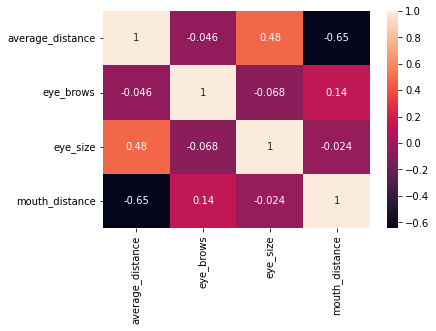

In [41]:
import seaborn as sns
X = df[df.columns.difference(['Unnamed: 0', 'emotion', 'image'])]
corr = X.corr()

sns.heatmap(corr, annot=True)


In [34]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]
data = X[selected_columns]
print(data)

       average_distance  eye_brows   eye_size  mouth_distance
0             57.849661      -14.0  19.570414      -28.666667
1             38.702801      -13.0  17.217604       -3.000000
2             48.809134      -15.5  14.625005      -13.333333
3             54.846611      -16.5  15.454924      -20.000000
4             37.752899      -17.5  16.119976        1.666667
...                 ...        ...        ...             ...
24108         44.369616      -27.0  25.488550       -3.333333
24109         63.395024      -21.5  18.033396      -19.666667
24110         75.326098      -14.5  21.125452      -47.666667
24111         65.942962      -27.0  23.877921      -23.333333
24112         51.818989      -25.0  18.477102      -13.333333

[24073 rows x 4 columns]


In [49]:
df.columns

Index(['image', 'emotion', 'mouth_distance', 'average_distance', 'eye_size',
       'eye_brows'],
      dtype='object')

In [37]:
from sklearn.ensemble import RandomForestClassifier
model= RandomForestClassifier(n_estimators=250, random_state=7)
X=df[df.columns.difference['emotion']]
y = df[['emotion']]
model.fit(X,y)

/var/folders/dj/6xj2_ws50cn8fvd7lpqt77l80000gn/T/ipykernel_3255/492002760.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X,y)


RandomForestClassifier(n_estimators=250, random_state=7)

In [38]:
model.feature_importances_

array([0.23298408, 0.29203108, 0.28612918, 0.18885565])

(4, 4)


,PC1,PC2,PC3,PC4
average_distance,0.687100,0.130800,-0.126600,0.703400
eye_brows,-0.165300,0.732200,-0.654300,-0.092400
eye_size,0.421100,0.562200,0.580800,-0.411400
mouth_distance,-0.568500,0.361600,0.467500,0.572300


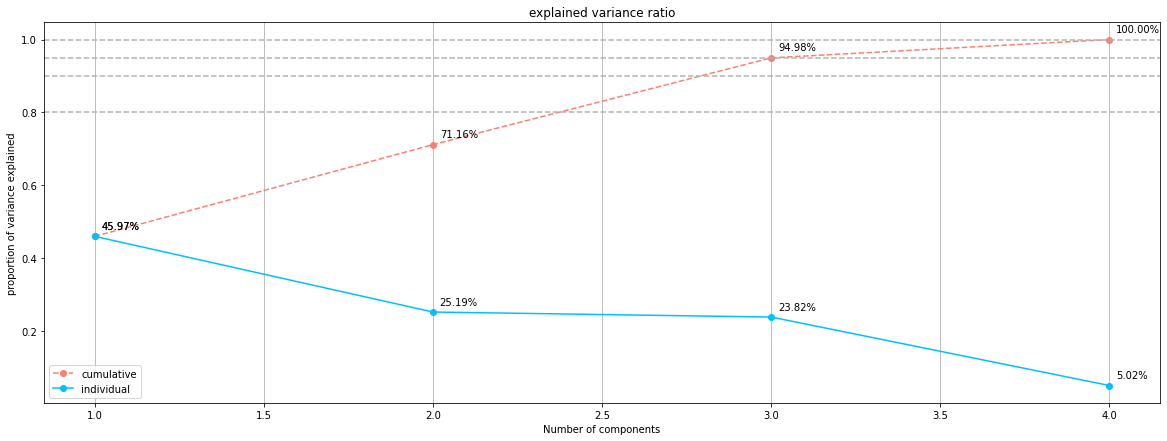

In [31]:
# Plot PCA Graph

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA(n_components=4)
X_t = scaler.fit_transform(X)
pca.fit_transform(X_t)
scree_plot(X, 4, True, True, (20 , 7))
cols=['average_distance', 'eye_brows', 'eye_size', 'mouth_distance']
print(pca.components_.shape)
dpc=pd.DataFrame(pca.components_.T, 
                  index=cols, 
                  columns=[f'PC{n+1}' for n in range(pca.components_.shape[0])]).round(4) #Eigenvectors
                  
# dpc
dpc.style.applymap(lambda e: 'background-color: gray' if e > .5 else 'background-color: dark-white')

In [ ]:
# Wrapper Methods
